<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Spatial Data Lab

_Authors: Matt Brems (DC)_

## NYC Data Component
You should consult the [Geopandas Practice Notbook](geopandas-practice.ipynb) before diving into this lab.

In that notebook, you're introduced to the `GeoDataFrame` object from `geopandas`. A `GeoDataFrame` is just like a `DataFrame`, except it contains a `geometry` column that identifies each row as an object in space. A row can either represent a point in space (in which case the `geometry` column contains `Points`) or an area (in which case the `geometry` column contains `Polygons`). A `GeoDataFrame` can contain more than one column which contains spatial information, but only one column at a time can identify the unique geometry of an observation.

Here, we'll practice some of the same functionality and concepts.

In [1]:
# basic stuff
import os
import pandas as pd
import numpy as np
from datetime import datetime
from urllib.request import urlretrieve
from zipfile import ZipFile
import pysal

# geo stuff
import geopandas as gpd
from shapely.geometry import Point
# from ipyleaflet import (Map,
#     Marker,
#     TileLayer, ImageOverlay,
#     Polyline, Polygon, Rectangle, Circle, CircleMarker,
#     GeoJSON,
#     DrawControl
# )

# plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (10.0, 10.0)

# widget stuff
from ipywidgets import interact, HTML, FloatSlider
from IPython.display import clear_output, display

# progress stuff
from tqdm import tqdm_notebook, tqdm_pandas

# turn warnings off
import warnings
warnings.filterwarnings('ignore')

In [2]:
# from the Geopandas practice notebook:

def get_nyc_shape_file(url, filename):

    # download file
    zipped = filename + '.zip'
    urlretrieve('https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile', zipped)
    zipped = os.getcwd() + '/' + zipped

    # unzip file
    to_unzip = ZipFile(zipped, 'r')
    unzipped = os.getcwd() + '/' + filename + '_unzipped'
    to_unzip.extractall(unzipped)
    to_unzip.close()

    # get shape file
    for file in os.listdir(unzipped):
        if file.endswith(".shp"):
            shape_file = unzipped + '/' + file

    # return full file path
    return shape_file

# get shape file path
shape_file_url = 'https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile'
shape_file_dir = 'nyc_boroughs'
file_path = get_nyc_shape_file(shape_file_url,shape_file_dir)

# read and view GeoDataFrame
gdf = gpd.GeoDataFrame.from_file(file_path)
gdf.head()

,boro_name,boro_code,shape_leng,shape_area,geometry
0,Manhattan,1.0,361649.881587,6.366006e+08,(POLYGON ((-74.01092841268031 40.6844914725429...
1,Bronx,2.0,463464.521828,1.186615e+09,(POLYGON ((-73.89680883223774 40.7958084451597...
2,Staten Island,5.0,330432.867999,1.623921e+09,(POLYGON ((-74.05050806403247 40.5664220341608...
3,Brooklyn,3.0,739945.437431,1.937567e+09,(POLYGON ((-73.86706149472118 40.5820879767934...
4,Queens,4.0,895228.960360,3.044772e+09,(POLYGON ((-73.83668274106707 40.5949466970158...


#### To begin, return a `Series` containing the area of each NYC borough.

Does it match the area we are given? What units do you think these columns are in?

You will want to consult [the Geopandas docs](http://geopandas.org/reference.html) to familiarize yourself with the special attributes and methods of `GeoSeries` and `GeoDataFrame` objects.

In [3]:
gdf['area'] = gdf.area
gdf

,boro_name,boro_code,shape_leng,shape_area,geometry,area
0,Manhattan,1.0,361649.881587,6.366006e+08,(POLYGON ((-74.01092841268031 40.6844914725429...,0.006309
1,Bronx,2.0,463464.521828,1.186615e+09,(POLYGON ((-73.89680883223774 40.7958084451597...,0.011773
2,Staten Island,5.0,330432.867999,1.623921e+09,(POLYGON ((-74.05050806403247 40.5664220341608...,0.016047
3,Brooklyn,3.0,739945.437431,1.937567e+09,(POLYGON ((-73.86706149472118 40.5820879767934...,0.019164
4,Queens,4.0,895228.960360,3.044772e+09,(POLYGON ((-73.83668274106707 40.5949466970158...,0.030143


#### Add a new column to the dataset containing the centroid of each borough.

What type of object is this? What type of object does it contain?
Can we make this the `geometry` column for this dataset?

In [4]:
gdf['centroid'] = gdf.centroid
gdf

,boro_name,boro_code,shape_leng,shape_area,geometry,area,centroid
0,Manhattan,1.0,361649.881587,6.366006e+08,(POLYGON ((-74.01092841268031 40.6844914725429...,0.006309,POINT (-73.96716968771112 40.77726401016272)
1,Bronx,2.0,463464.521828,1.186615e+09,(POLYGON ((-73.89680883223774 40.7958084451597...,0.011773,POINT (-73.86654163194733 40.85262967859273)
2,Staten Island,5.0,330432.867999,1.623921e+09,(POLYGON ((-74.05050806403247 40.5664220341608...,0.016047,POINT (-74.15336979029414 40.58085472747923)
3,Brooklyn,3.0,739945.437431,1.937567e+09,(POLYGON ((-73.86706149472118 40.5820879767934...,0.019164,POINT (-73.94767501523242 40.64473132725909)
4,Queens,4.0,895228.960360,3.044772e+09,(POLYGON ((-73.83668274106707 40.5949466970158...,0.030143,POINT (-73.81849453624231 40.70760815187309)


#### Now, plot the NYC boroughs, the convex hull for each borough, and the envelope for each borough.

Hint: You can call `.plot` on a `GeoDataFrame`.

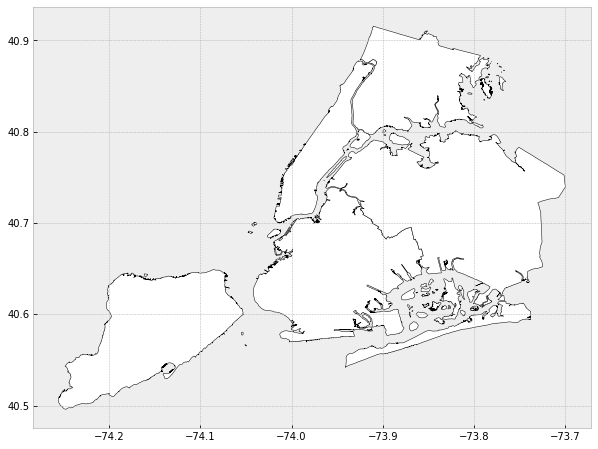

In [5]:
gdf.plot(color='white', edgecolor='black');

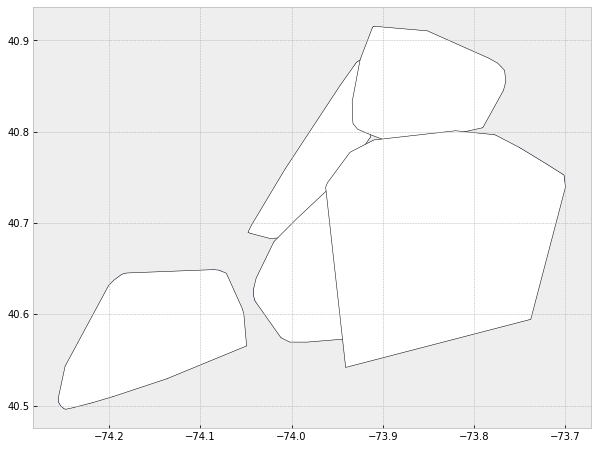

In [6]:
# create convex hulls
hulls = gdf['geometry'].convex_hull

# plot overlay
hulls.plot(ax=gdf.plot(), color='white', edgecolor='black');

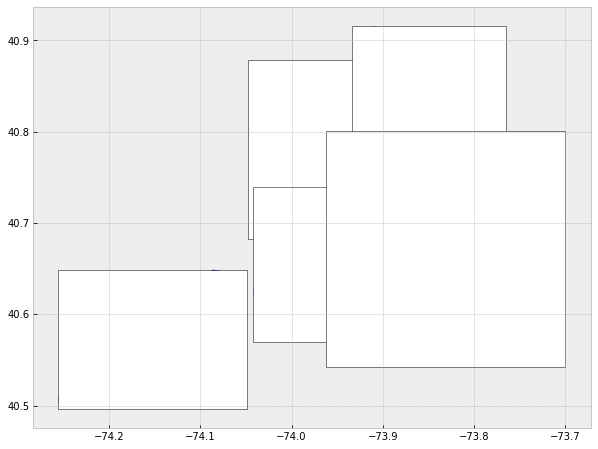

In [7]:
# create envelopes
envelope = gpd.GeoSeries(hulls.envelope)

# plot overlay
envelope.plot(ax=gdf.plot(), color='white', edgecolor='black');

#### Bonus: Plot the centroid of each borough on the map of each borough

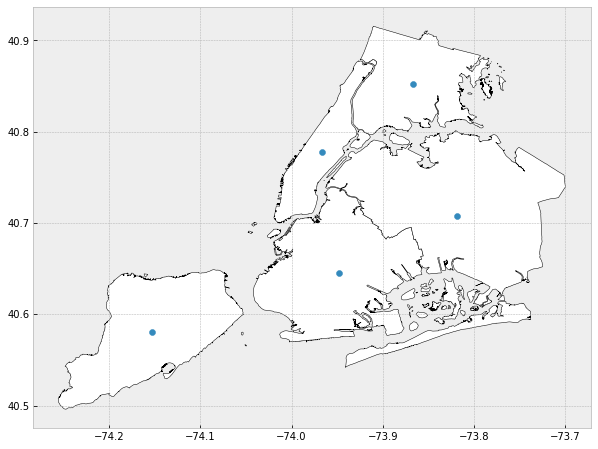

In [8]:
gdf.centroid.plot(ax=gdf.plot(color='white', edgecolor='black'));

#### Generate 10,000 samples uniformly across the NYC map. 

Note, you're generating both a random X and a random Y in order to get a location on the NYC map, much like how you might estimate $\pi$ using Monte Carlo simulations.

Plot these points over the map of NYC.

In [9]:
def generate_points(n, gdf=gdf):

    # get min/max coordinates
    min_x, min_y = gdf.bounds[['minx','miny']].min()
    max_x, max_y = gdf.bounds[['maxx','maxy']].max()

    # generate n random points
    x_vals = np.random.uniform(min_x, max_x, n)
    y_vals = np.random.uniform(min_y, max_y, n)
    points = zip(x_vals, y_vals)

    # return dataframe
    points_df = pd.DataFrame(list(points), columns=['x', 'y'])
    return(points_df)

# simulate points
sim_points = generate_points(10000, gdf=gdf)
sim_points.head()

,x,y
0,-73.787771,40.575724
1,-73.717043,40.866056
2,-74.123687,40.631677
3,-74.181236,40.751088
4,-73.749720,40.655559


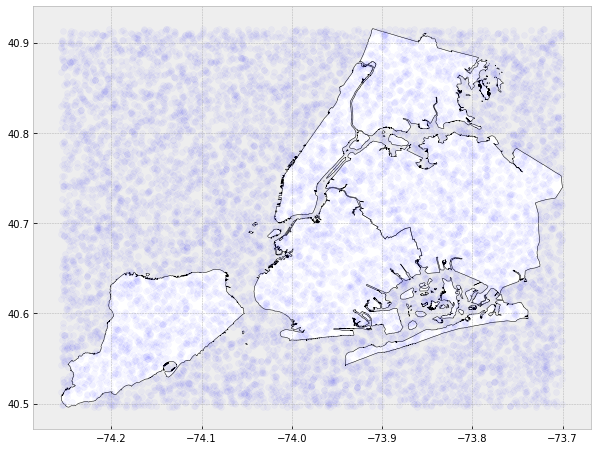

In [10]:
# plot simulated data points on map
gdf.plot(color='white', edgecolor='black')
plt.scatter(x=sim_points['x'], y=sim_points['y'], alpha=0.03, c='b');

#### Place points within boroughs
A common geosptial task is to check whether a given point lies inside or outside of a certain area. In order to ease that calculation, convex hulls and envelopes are often used as approximations of the true shape of geographical areas.

In this part, we'll check which (if any) each borough our simulated points fall into:

- Whether or not each sample falls in the true geographic boroughs.
- Whether or not each sample falls in the convex hulls of the boroughs.
- Whether or not each sample falls in the envelopes of the boroughs.

We'll need to use the `Point` object that we imported from `shapely` and the `.contains` method from Geopandas.

At each step, use the `%%timeit` [magic command](https://ipython.readthedocs.io/en/stable/interactive/magics.html) to measure how long this process takes.

Report these numbers, as well as how much more efficient (percentage-wise) envelopes and convex hulls are relative to the true geographies.

In [13]:
sim_points['points'] = [Point(xy) for xy in zip(sim_points['x'], sim_points['y'])]

In [14]:
sim_points.head()

,x,y,points
0,-73.787771,40.575724,POINT (-73.78777131682494 40.5757242078864)
1,-73.717043,40.866056,POINT (-73.71704342741162 40.86605589884157)
2,-74.123687,40.631677,POINT (-74.12368731883623 40.63167730076496)
3,-74.181236,40.751088,POINT (-74.18123634699994 40.75108820253146)
4,-73.749720,40.655559,POINT (-73.74972013406914 40.655559262816)


In [16]:
def locate_point(point, geo_series=gdf.geometry):
    '''Quick and dirty way of identifying which borough contains a point.'''
    try:
        return gdf['boro_name'][geo_series.contains(point)].values[0]
    except:
        return "No Borough"
    
locate_point(sim_points['points'][0])

'No Borough'

In [17]:
locate_point(sim_points['points'][0], geo_series=hulls)

'No Borough'

In [24]:
%%timeit

sim_points['Real Borough'] = sim_points['points'].apply(locate_point)

1min 35s ± 5.34 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
%%timeit

sim_points['Convex Hull'] = sim_points['points'].apply(locate_point,
                                                       geo_series=hulls)

4.25 s ± 914 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
%timeit

sim_points['Envelope'] = sim_points['points'].apply(locate_point,
                                                       geo_series=envelope)

In [27]:
# Using convex hulls takes 4.25 / 95 ~ 4% as much time as the true geography!


In [28]:
sim_points.head(10)

,x,y,points,Real Borough,Convex Hull,Envelope
0,-73.787771,40.575724,POINT (-73.78777131682494 40.5757242078864),No Borough,No Borough,Queens
1,-73.717043,40.866056,POINT (-73.71704342741162 40.86605589884157),No Borough,No Borough,No Borough
2,-74.123687,40.631677,POINT (-74.12368731883623 40.63167730076496),Staten Island,Staten Island,Staten Island
3,-74.181236,40.751088,POINT (-74.18123634699994 40.75108820253146),No Borough,No Borough,No Borough
4,-73.749720,40.655559,POINT (-73.74972013406914 40.655559262816),Queens,Queens,Queens
5,-73.871476,40.775630,POINT (-73.87147586344003 40.77563020236984),Queens,Queens,Queens
6,-74.135952,40.905449,POINT (-74.1359523848451 40.90544917156834),No Borough,No Borough,No Borough
7,-74.062747,40.653600,POINT (-74.062746661921 40.65360012120615),No Borough,No Borough,No Borough
8,-73.973815,40.839242,POINT (-73.97381508157595 40.83924234097558),No Borough,No Borough,Manhattan
9,-74.049595,40.685723,POINT (-74.04959528379386 40.68572319231271),No Borough,No Borough,No Borough


#### Generate metrics.  Summarize findings.

Obviously there's a trade-off here. Check how many samples lie in the actual geographies, the convex hulls, and the envelopes.

Report the following:

- A confusion matrix comparing convex hulls and actual geographies. (i.e. actual geographies are the true counts; convex hulls are predicted counts)
- A confusion matrix comparing envelopes and actual geographies.
- The accuracy and sensitivity from each of the confusion matrices above. You should report a sensitivity value for each borough.
- A paragraph summarizing your findings.

In [29]:
boroughs = gdf['boro_name'].unique()

In [30]:
cm = pd.DataFrame(np.zeros((5,5), int), index=boroughs, columns=boroughs)

for actual_borough in boroughs:
    for pred_borough   in boroughs:
        try:
            cm.loc[actual_borough, pred_borough] = sim_points.loc[
                sim_points['Real Borough'] == actual_borough,
                'Convex Hull'].value_counts()[pred_borough]
        except:
            cm.loc[actual_borough, pred_borough] = 0
cm.columns = ['Pred_' + borough for borough in cm.columns]
cm.index   = ['Actual_' + borough for borough in cm.index]

cm

,Pred_Manhattan,Pred_Bronx,Pred_Staten Island,Pred_Brooklyn,Pred_Queens
Actual_Manhattan,269,0,0,0,0
Actual_Bronx,48,441,0,0,0
Actual_Staten Island,0,0,689,0,0
Actual_Brooklyn,9,0,0,815,0
Actual_Queens,17,2,0,62,1208


In [31]:
convex_hull_TP = sum(np.diagonal(cm))
accuracy_convex_hull = convex_hull_TP/cm.sum().sum()
print("Accuracy of borough convex hulls: {}".format(accuracy_convex_hull))

Accuracy of borough convex hulls: 0.9612359550561798


In [32]:
def sensitivity(borough):
    TP = cm.loc['Actual_' + borough, 'Pred_' + borough]
    TP_FN = sum(cm['Pred_' + borough])
    return TP / (TP_FN)
print('Sensitivity per Borough:')
list(zip(boroughs, [sensitivity(borough) for borough in boroughs]))

Sensitivity per Borough:


[('Manhattan', 0.78425655976676389),
 ('Bronx', 0.99548532731376971),
 ('Staten Island', 1.0),
 ('Brooklyn', 0.92930444697833525),
 ('Queens', 1.0)]

In [33]:
cm = pd.DataFrame(np.zeros((5,5), int), index=boroughs, columns=boroughs)

for actual_borough in boroughs:
    for pred_borough   in boroughs:
        try:
            cm.loc[actual_borough, pred_borough] = sim_points.loc[
                sim_points['Real Borough'] == actual_borough,
                'Envelope'].value_counts()[pred_borough]
        except:
            cm.loc[actual_borough, pred_borough] = 0
cm.columns = ['Pred_' + borough for borough in cm.columns]
cm.index   = ['Actual_' + borough for borough in cm.index]

cm

,Pred_Manhattan,Pred_Bronx,Pred_Staten Island,Pred_Brooklyn,Pred_Queens
Actual_Manhattan,269,0,0,0,0
Actual_Bronx,57,432,0,0,0
Actual_Staten Island,0,0,689,0,0
Actual_Brooklyn,149,0,0,675,0
Actual_Queens,104,30,0,237,918


In [34]:
envelope_TP = sum(np.diagonal(cm))
accuracy_envelope = envelope_TP/cm.sum().sum()
print("Accuracy of borough envelopes: {0:2f}".format(accuracy_envelope))

Accuracy of borough envelopes: 0.837921


In [35]:
def sensitivity(borough):
    TP = cm.loc['Actual_' + borough, 'Pred_' + borough]
    TP_FN = sum(cm['Pred_' + borough])
    return TP / (TP_FN)
print('Sensitivity per Borough:')
list(zip(boroughs, [sensitivity(borough) for borough in boroughs]))

Sensitivity per Borough:


[('Manhattan', 0.46459412780656306),
 ('Bronx', 0.93506493506493504),
 ('Staten Island', 1.0),
 ('Brooklyn', 0.74013157894736847),
 ('Queens', 1.0)]

In [36]:
# Unsurprisingly, using convex hulls to approximate the shape of each borough
# substantially outperforms using only the envelope. In both cases, Manhattan
# tends to be obscured by other boroughs, but much more so in the case of the
# envelope. In fact, using the Manhattan envelope correctly identifies a point
# as belonging in Manhattan less than half of the time!

# Staten Island and Queens, on the other hand, are relatively well approximated
# by convex hulls and by envelopes. This is unsurprising in the case of Staten 
# Island which is -- wait for it -- an island! Therefore its approximations do 
# not overlap the approximations of other boroughs. All of this excludes the
# points that did not fall in any borough, which we did not track in our 
# confusion matrix.

#### Perform a spatial join using your simulated data

You should consider the [Geopandas docs](http://geopandas.readthedocs.io/en/latest/reference/geopandas.sjoin.html).

Hint: You must use two `GeoDataFrame`s
Hint: Use `crs= {'init' :'epsg:4326'}`

##### First, use `sjoin` to label each simulated point according to its corresponding borough
This should give the same results as above, when you used `.contains` to check and see which borough each point belonged to.

In [37]:
sim_points = gpd.GeoDataFrame(sim_points, geometry='points', crs= {'init' :'epsg:4326'})

In [38]:
merged_points = gpd.sjoin(sim_points, gdf, how='left', op='within')

In [41]:
merged_points[merged_points['Real Borough'] != "No Borough"].head(10)

,x,y,points,Real Borough,Convex Hull,Envelope,index_right,boro_name,boro_code,shape_leng,shape_area,area,centroid
2,-74.123687,40.631677,POINT (-74.12368731883623 40.63167730076496),Staten Island,Staten Island,Staten Island,2.0,Staten Island,5.0,330432.867999,1.623921e+09,0.016047,POINT (-74.15336979029414 40.58085472747923)
4,-73.749720,40.655559,POINT (-73.74972013406914 40.655559262816),Queens,Queens,Queens,4.0,Queens,4.0,895228.960360,3.044772e+09,0.030143,POINT (-73.81849453624231 40.70760815187309)
5,-73.871476,40.775630,POINT (-73.87147586344003 40.77563020236984),Queens,Queens,Queens,4.0,Queens,4.0,895228.960360,3.044772e+09,0.030143,POINT (-73.81849453624231 40.70760815187309)
10,-73.918753,40.841786,POINT (-73.91875280730817 40.8417864461021),Bronx,Manhattan,Manhattan,1.0,Bronx,2.0,463464.521828,1.186615e+09,0.011773,POINT (-73.86654163194733 40.85262967859273)
12,-74.078047,40.601237,POINT (-74.07804749067263 40.60123745970699),Staten Island,Staten Island,Staten Island,2.0,Staten Island,5.0,330432.867999,1.623921e+09,0.016047,POINT (-74.15336979029414 40.58085472747923)
13,-74.083819,40.640888,POINT (-74.0838190231235 40.64088750754443),Staten Island,Staten Island,Staten Island,2.0,Staten Island,5.0,330432.867999,1.623921e+09,0.016047,POINT (-74.15336979029414 40.58085472747923)
16,-73.893644,40.905670,POINT (-73.89364406457575 40.90566966312587),Bronx,Bronx,Bronx,1.0,Bronx,2.0,463464.521828,1.186615e+09,0.011773,POINT (-73.86654163194733 40.85262967859273)
17,-73.805896,40.666482,POINT (-73.80589607725859 40.66648217674985),Queens,Queens,Queens,4.0,Queens,4.0,895228.960360,3.044772e+09,0.030143,POINT (-73.81849453624231 40.70760815187309)
19,-73.829684,40.769859,POINT (-73.82968358901742 40.76985878421036),Queens,Queens,Queens,4.0,Queens,4.0,895228.960360,3.044772e+09,0.030143,POINT (-73.81849453624231 40.70760815187309)
21,-73.925894,40.746470,POINT (-73.92589394639289 40.7464697068238),Queens,Queens,Manhattan,4.0,Queens,4.0,895228.960360,3.044772e+09,0.030143,POINT (-73.81849453624231 40.70760815187309)


##### Bonus: Use `sjoin` to count the number of points in each borough.

#### Generate a map of NYC with each borough shaded based on the number of pick-ups that occur in each borough.

In [42]:
import pandas as pd

In [44]:
## This will take awhile! Check out the data dictionary in the meantime: 
## http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf

taxi = pd.read_csv("https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-09.csv")

In [45]:
taxi.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-09-01 00:05:55,2015-09-01 00:31:02,1,17.45,-73.791351,40.646690,1,N,-73.857437,40.848263,1,47.5,0.5,0.5,5.00,5.54,0.3,59.34
1,1,2015-09-01 00:05:56,2015-09-01 00:07:42,1,0.40,-73.978935,40.752853,1,N,-73.986061,40.755398,2,3.5,0.5,0.5,0.00,0.00,0.3,4.80
2,1,2015-09-01 00:05:57,2015-09-01 00:16:48,1,1.50,-73.990891,40.723972,1,N,-74.009560,40.728916,2,9.0,0.5,0.5,0.00,0.00,0.3,10.30
3,1,2015-09-01 00:05:57,2015-09-01 00:05:57,1,0.00,-73.932655,40.803768,1,N,0.000000,0.000000,2,4.0,0.5,0.5,0.00,0.00,0.3,5.30
4,1,2015-09-01 00:05:57,2015-09-01 00:30:32,1,7.50,-73.987778,40.738194,1,N,-73.944756,40.828167,1,23.5,0.5,0.5,4.95,0.00,0.3,29.75


In [46]:
taxi['pickup_points'] = [Point(xy) for xy in zip(taxi['pickup_latitude'], taxi['pickup_longitude'])]

In [ ]:
taxi['Borough'] = taxi['pickup_points'].apply(locate_point)

In [ ]:
taxi.groupby('Borough')['VendorID'].count()

In [ ]:
#### My computer timed out :(

#### Suppose we want to forecast the number of pick-ups by borough. Would this process be described as areal, geostatistical, or point pattern?

In [ ]:
# Although pick-ups are a point pattern process, when we aggregate their number
# by borough, we're forecasting an areal process.

#### Bonus: Build a widget that will put dots on the map for the location of each pick-up by date.
Using the exact latitude and longitude will cause multiple dots to overlap; people often use a [random jitter](https://www.dataplusscience.com/TableauJitter.html) to help with this. While not required, consider random jitter as an extra bonus!

#### In order to predict the precise location of pick-ups, would this process be described as areal, geostatistical, or point pattern?

In [ ]:
# This would be a point pattern process, because we're identifying the precise
# location in space, without aggregation by area.